# AutoSteer Project

## detect middle line on a road inside FS22

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import sklearn
import glob
import math

In [3]:
def roi(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask,vertices,255)
    masked = cv2.bitwise_and(img, mask)
    return masked

In [4]:
def readImg(path):
    
    #img = cv2.imread("./images/img2.png")
    img = cv2.imread(path)
    size = (1280, 720)
    img = cv2.resize(img, size)
    org_img = np.copy(img)
    return org_img

def hsv(hsv_img):
    hsv = cv2.cvtColor(hsv_img, cv2.COLOR_BGR2HSV)
    sensitivity = 70
    lower_white = np.array([0,0,255-sensitivity])
    upper_white = np.array([255,sensitivity,255])
    mask = cv2.inRange(hsv, lower_white, upper_white)
    res = cv2.bitwise_and(hsv_img,hsv_img, mask= mask)
    #hsv_img = res
    return res


In [27]:
def canny_and_roi(img,in_roi):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(img_gray,(kernel_size, kernel_size),0)
    #cv2.imshow('image',blur_gray)
    #cv2.waitKey()
    #cv2.destroyAllWindows()
    low_threshold = 120
    high_threshold = 265
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    if in_roi:
    #roi_vertices = vertices = np.array([[0,500],[10,300], [300,200], [500,200], [800,300], [800,500]], np.int32)
        roi_vertices = np.array([[340,700],[340,300], [250,80], [530,80], [880,300], [880,700]], np.int32)
        processed_img = roi(edges, [roi_vertices])
        return processed_img
    else:
        return edges



In [5]:
def hough(h_img,org_img):
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 50  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40  # minimum number of pixels making up a line
    max_line_gap = 35  # maximum gap in pixels between connectable line segments
    line_image = np.copy(org_img) # * 0  # creating a blank to draw lines on
    size = (1280, 720)
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(h_img, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)
    line_m = []
    y_max = 800
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,255,0),2)
            m = (y2-y1)/(x2-x1)
            if x2<size[0]/2:
                if m < -6 :
                    line_m += [m]

                #get 
                if y1 < y_max:
                    y_max = y1
                    line_max = (x1,y1)
                if y2 < y_max:
                    y_max = y2
                    line_max = (x2,y2)

    print("point with maximum y value (near bottom of screen): ",line_max)        
    print("all m of lines: ",line_m)
    mean_m = np.mean(line_m)
    print("avergae m of lines: ",mean_m)

    #Geradengleichung y = mx + n
    #n = y-m*x
    n = line_max[1] - mean_m * line_max[0]
    print("average line n: ",n)


    #draw line with average m from bottom point of all lines to edge of screen point
    edge_screen_y = 700
    edge_screen_x = (edge_screen_y - n)/mean_m
    edge_point = (int(edge_screen_x),int(edge_screen_y))

    cv2.circle(line_image,line_max,5,(255,0,255),5)   
    cv2.circle(line_image,edge_point,5,(255,0,255),5)  
    cv2.line(line_image,line_max,edge_point,(255,0,255),2)

    #draw image center
    cv2.circle(line_image,(int(size[0]/2),int(size[1]/2)),5,(255,255,255),5)        


    #draw middle line at center
    middle_screen_y = size[1]/2
    middle_screen_x = (middle_screen_y - n)/mean_m
    middle_point = (int(middle_screen_x),int(middle_screen_y))
    cv2.circle(line_image,middle_point,5,(255,0,255),5)  

    #calc distance between line and center at center height
    print("diff line: ",size[0]/2 - middle_screen_x)



    return line_image, size[0]/2 - middle_screen_x
    #cv2.imshow('image',line_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

point with maximum y value (near bottom of screen):  (581, 112)
all m of lines:  [-13.5, -10.714285714285714, -11.714285714285714, -11.0, -12.083333333333334, -11.2, -11.5]
avergae m of lines:  -11.673129251700681
average line n:  6894.088095238096
diff line:  80.24537428246742


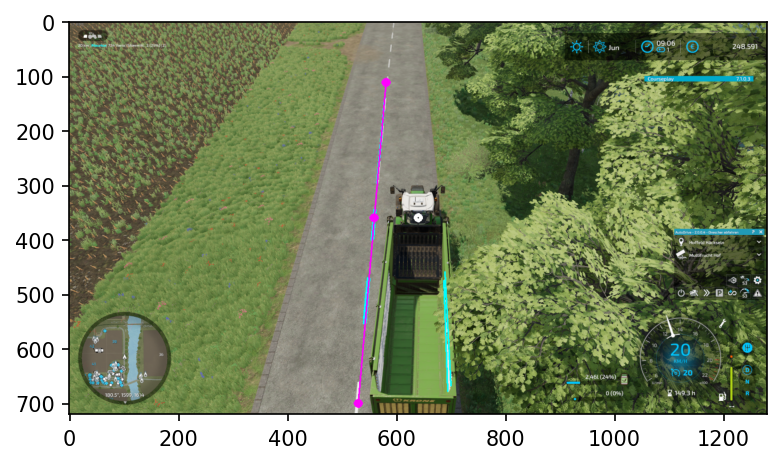

In [8]:
img = readImg("./images/img5.png")
img1 = hsv(img)
processed_img = canny_and_roi(img1)
processed_img1,diff = hough(processed_img,img)
plt.figure(figsize=(6, 4), dpi=150)
plt_img = cv2.cvtColor(processed_img1,cv2.COLOR_BGR2RGB)
plt.imshow(plt_img)

Problem with other lines detected

In [9]:
diffs = []
for file in glob.glob("./sequence/1/*.png"):
    print(file)
    img = readImg(file)
    img1 = hsv(img)
    processed_img = canny_and_roi(img1)
    processed_img1,diff = hough(processed_img,img)
    diffs += [diff]
    cv2.imshow('image',processed_img1)
    cv2.waitKey()
cv2.destroyAllWindows()
print(diffs)
#compare current distance between middle point and line middle and the distance in the frame before
#steer accordingly
#at the beginning: set an optimal distance

./sequence/1\fsScreen_2022_11_10_16_54_27.png
point with maximum y value (near bottom of screen):  (581, 112)
all m of lines:  [-13.5, -10.714285714285714, -11.714285714285714, -11.0, -12.083333333333334, -11.2, -11.5]
avergae m of lines:  -11.673129251700681
average line n:  6894.088095238096
diff line:  80.24537428246742
./sequence/1\fsScreen_2022_11_10_16_54_29.png
point with maximum y value (near bottom of screen):  (610, 130)
all m of lines:  [-6.384615384615385, -6.8, -7.166666666666667]
avergae m of lines:  -6.783760683760684
average line n:  4268.094017094017
diff line:  63.90449792112895
./sequence/1\fsScreen_2022_11_10_16_54_30.png
point with maximum y value (near bottom of screen):  (618, 144)
all m of lines:  [-6.4, -6.346153846153846, -11.2, -28.666666666666668]
avergae m of lines:  -13.153205128205128
average line n:  8272.68076923077
diff line:  38.42185291680869
./sequence/1\fsScreen_2022_11_10_16_54_31.png


C:\Users\Maurice\AppData\Local\Temp\ipykernel_388\1593586388.py:18: RuntimeWarning: divide by zero encountered in int_scalars
  m = (y2-y1)/(x2-x1)


point with maximum y value (near bottom of screen):  (631, 145)
all m of lines:  [-6.222222222222222, -6.2592592592592595, -7.291666666666667, -7.5, -7.421052631578948, -7.04, -7.888888888888889]
avergae m of lines:  -7.089012809802284
average line n:  4618.167082985241
diff line:  39.328623430149605
./sequence/1\fsScreen_2022_11_10_16_54_32.png
point with maximum y value (near bottom of screen):  (638, 153)
all m of lines:  [-10.142857142857142, -8.666666666666666, -9.125, -8.176470588235293, -8.3]
avergae m of lines:  -8.882198879551819
average line n:  5819.84288515406
diff line:  25.305039980195147
./sequence/1\fsScreen_2022_11_10_16_54_33.png
point with maximum y value (near bottom of screen):  (634, 167)
all m of lines:  [-8.666666666666666, -7.75, -7.833333333333333]
avergae m of lines:  -8.083333333333332
average line n:  5291.833333333333
diff line:  29.876288659793772
./sequence/1\fsScreen_2022_11_10_16_54_34.png
point with maximum y value (near bottom of screen):  (635, 146)

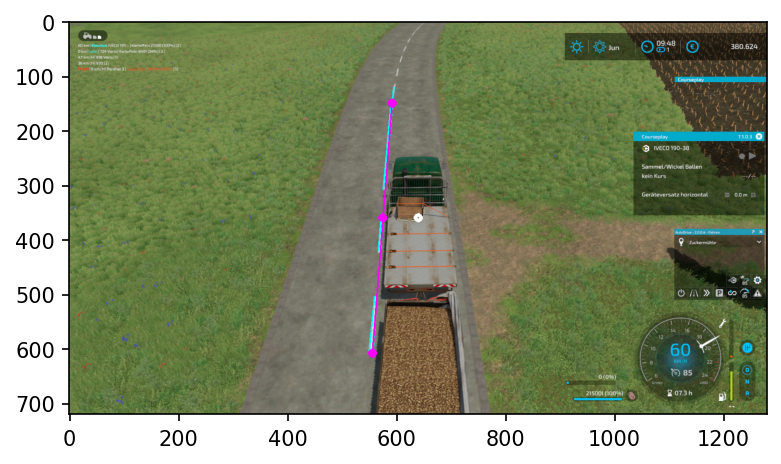

In [117]:
plt.figure(figsize=(6, 4), dpi=150)
plt_img = cv2.cvtColor(line_image,cv2.COLOR_BGR2RGB)
plt.imshow(plt_img)

## Detect outer edge of Car/Tractor

In [40]:
img = cv2.imread("./images/img1.png")
size = (1280, 720)
img = cv2.resize(img, size)
org_img = np.copy(img)
cv2.imshow('image',org_img)
cv2.waitKey()
cv2.destroyAllWindows()

In [45]:
#size = (1280, 720)
roi_box_size = 150
center = tuple(int(s/2) for s in size)
print(center)
roi_vertices_box = np.array([[center[0]-roi_box_size,center[1]-roi_box_size],
                         [center[0]-roi_box_size,center[1]+roi_box_size],
                         [center[0]+roi_box_size,center[1]+roi_box_size],
                         [center[0]+roi_box_size,center[1]-roi_box_size]], np.int32)
#img = cv2.cvtColor(org_img,cv2.COLOR_BGR2GRAY)
processed_img = roi(img, [roi_vertices_box])

cv2.imshow('image',processed_img)
cv2.waitKey()
cv2.destroyAllWindows()

(640, 360)


In [42]:
low_threshold = 130
high_threshold = 200
def on_low(val):
    global low_threshold
    low_threshold = val
    cv2.setTrackbarPos("low", 'Canny Edge Detection', low_threshold)
def on_high(val):
    global high_threshold
    high_threshold = val
    cv2.setTrackbarPos("high", 'Canny Edge Detection', high_threshold)

In [43]:
cv2.namedWindow('Canny Edge Detection')
cv2.createTrackbar("low",'Canny Edge Detection',0,255,on_low)
cv2.createTrackbar("high",'Canny Edge Detection',0,255,on_high)
low_threshold = 130
high_threshold = 200
while(1):
    edges = cv2.Canny(processed_img, low_threshold, high_threshold)
    cv2.imshow('Canny Edge Detection',edges)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()

In [44]:
low_threshold = 105
high_threshold = 255
edges = cv2.Canny(processed_img, low_threshold, high_threshold)
cv2.imshow('Canny Edge Detection',edges)
cv2.waitKey()
cv2.destroyAllWindows()

# TEST

https://stackoverflow.com/questions/45531074/how-to-merge-lines-after-houghlinesp

In [17]:
class HoughBundler:     
    def __init__(self,min_distance=5,min_angle=2):
        self.min_distance = min_distance
        self.min_angle = min_angle
    
    def get_orientation(self, line):
        orientation = math.atan2(abs((line[3] - line[1])), abs((line[2] - line[0])))
        return math.degrees(orientation)

    def check_is_line_different(self, line_1, groups, min_distance_to_merge, min_angle_to_merge):
        for group in groups:
            for line_2 in group:
                if self.get_distance(line_2, line_1) < min_distance_to_merge:
                    orientation_1 = self.get_orientation(line_1)
                    orientation_2 = self.get_orientation(line_2)
                    if abs(orientation_1 - orientation_2) < min_angle_to_merge:
                        group.append(line_1)
                        return False
        return True

    def distance_point_to_line(self, point, line):
        px, py = point
        x1, y1, x2, y2 = line

        def line_magnitude(x1, y1, x2, y2):
            line_magnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
            return line_magnitude

        lmag = line_magnitude(x1, y1, x2, y2)
        if lmag < 0.00000001:
            distance_point_to_line = 9999
            return distance_point_to_line

        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (lmag * lmag)

        if (u < 0.00001) or (u > 1):
            #// closest point does not fall within the line segment, take the shorter distance
            #// to an endpoint
            ix = line_magnitude(px, py, x1, y1)
            iy = line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance_point_to_line = iy
            else:
                distance_point_to_line = ix
        else:
            # Intersecting point is on the line, use the formula
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance_point_to_line = line_magnitude(px, py, ix, iy)

        return distance_point_to_line

    def get_distance(self, a_line, b_line):
        dist1 = self.distance_point_to_line(a_line[:2], b_line)
        dist2 = self.distance_point_to_line(a_line[2:], b_line)
        dist3 = self.distance_point_to_line(b_line[:2], a_line)
        dist4 = self.distance_point_to_line(b_line[2:], a_line)

        return min(dist1, dist2, dist3, dist4)

    def merge_lines_into_groups(self, lines):
        groups = []  # all lines groups are here
        # first line will create new group every time
        groups.append([lines[0]])
        # if line is different from existing gropus, create a new group
        for line_new in lines[1:]:
            if self.check_is_line_different(line_new, groups, self.min_distance, self.min_angle):
                groups.append([line_new])

        return groups

    def merge_line_segments(self, lines):
        orientation = self.get_orientation(lines[0])
      
        if(len(lines) == 1):
            return np.block([[lines[0][:2], lines[0][2:]]])

        points = []
        for line in lines:
            points.append(line[:2])
            points.append(line[2:])
        if 45 < orientation <= 90:
            #sort by y
            points = sorted(points, key=lambda point: point[1])
        else:
            #sort by x
            points = sorted(points, key=lambda point: point[0])

        return np.block([[points[0],points[-1]]])

    def process_lines(self, lines):
        lines_horizontal  = []
        lines_vertical  = []
  
        for line_i in [l[0] for l in lines]:
            orientation = self.get_orientation(line_i)
            # if vertical
            if 45 < orientation <= 90:
                lines_vertical.append(line_i)
            else:
                lines_horizontal.append(line_i)

        lines_vertical  = sorted(lines_vertical , key=lambda line: line[1])
        lines_horizontal  = sorted(lines_horizontal , key=lambda line: line[0])
        merged_lines_all = []

        # for each cluster in vertical and horizantal lines leave only one line
        for i in [lines_horizontal, lines_vertical]:
            if len(i) > 0:
                groups = self.merge_lines_into_groups(i)
                merged_lines = []
                for group in groups:
                    merged_lines.append(self.merge_line_segments(group))
                merged_lines_all.extend(merged_lines)
                    
        return np.asarray(merged_lines_all)


In [85]:
# Usage:
img = readImg("images/img3.png")
edges = canny_and_roi(img,True)
#lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, None, 50, 10)


rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 70  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 45  # minimum number of pixels making up a line
max_line_gap = 75  # maximum gap in pixels between connectable line segments
#line_image = np.copy(org_img) # * 0  # creating a blank to draw lines on
size = (1280, 720)
# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines_normal = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
bundler = HoughBundler(min_distance=5,min_angle=0)
lines = bundler.process_lines(lines_normal)
print(lines)
line_image = np.copy(img)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,255,0),4)

for line in lines_normal:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(0,0,0),1)
cv2.imshow('image',line_image)
cv2.waitKey()
cv2.destroyAllWindows()

[[[542 412 556 202]]

 [[544 412 554 258]]

 [[525 640 536 512]]

 [[517 641 528 516]]]


# 